#### Setting up LLM and all the tools

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

In [2]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [3]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=350)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
tavily = TavilySearchResults()

C:\Users\Soham\AppData\Local\Temp\ipykernel_10604\2720876434.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [5]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [6]:
tools = [add, multiply, divide, arxiv, wiki, tavily]

In [7]:
from langchain_core.messages import HumanMessage

llm_with_tools = llm.bind_tools(tools)

In [8]:
llm_with_tools.invoke([HumanMessage("Calculate the product of 20 and 5?")]).tool_calls

[{'name': 'multiply',
  'args': {'a': 20, 'b': 5},
  'id': 'f6myrpcr6',
  'type': 'tool_call'}]

#### Creating the State Schema and a Tool Agent

In [9]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

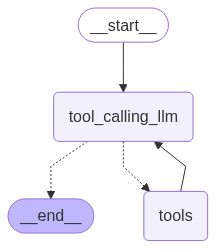

In [10]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
from pprint import pprint

messages = graph.invoke({"messages": HumanMessage(content=f"Provide me with latest Pokemn TCG news, then perform addition of largest two digit number with largest three digit number. Finally, divide that sum by the smallest prime number!")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Provide me with latest Pokemn TCG news, then perform addition of largest two digit number with largest three digit number. Finally, divide that sum by the smallest prime number!
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (9mz7d3jr8)
 Call ID: 9mz7d3jr8
  Args:
    query: latest Pokemon TCG news
  add (9ajdsg7qs)
 Call ID: 9ajdsg7qs
  Args:
    a: 99
    b: 999
  divide (apt96vyj3)
 Call ID: apt96vyj3
  Args:
    a: 1098
    b: 2
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "PokeGuardian | The Latest Pokémon TCG News and Updates Daily", "url": "https://www.pokeguardian.com/", "content": "## [Scarlet & Violet - Black Bolt and Scarlet & Violet - White Flare Officially Revealed as Split Expansion for Pokémon TCG International Release](/2490337_scarlet-

In [12]:
messages = graph.invoke({"messages": HumanMessage(content=f"What are transformers in Generative AI? Multiply 78 with 3 and then divide the result by 6.")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What are transformers in Generative AI? Multiply 78 with 3 and then divide the result by 6.
================================== Ai Message ==================================
Tool Calls:
  multiply (6p0dd1893)
 Call ID: 6p0dd1893
  Args:
    a: 78
    b: 3
  divide (rzak65gn8)
 Call ID: rzak65gn8
  Args:
    a: 234
    b: 6
  wikipedia (xdaxgjgh5)
 Call ID: xdaxgjgh5
  Args:
    query: Transformers in Generative AI
================================= Tool Message =================================
Name: multiply

234
================================= Tool Message =================================
Name: divide

39.0
================================= Tool Message =================================
Name: wikipedia

Page: Generative pre-trained transformer
Summary: A generative pre-trained transformer (GPT) is a type of large language model (LLM) and a prominent framework for generative artificial intelligence. It 

#### Using MemorySaver to build chatbot using conversation history

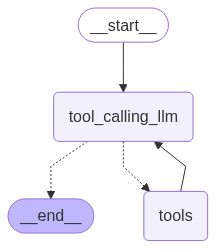

In [13]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph_memory = builder.compile(checkpointer=memory)
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [14]:
config = {"configurable":{"thread_id":1}}

In [15]:
messages = [HumanMessage(content=f"What is 12+13?")]
msgs = graph_memory.invoke({"messages":messages},config=config)
for m in msgs["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 12+13?
================================== Ai Message ==================================
Tool Calls:
  add (fg59m0qgd)
 Call ID: fg59m0qgd
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The answer is 25.


In [16]:
messages = [HumanMessage(content=f"Now multiply it by 4.")]
msgs = graph_memory.invoke({"messages":messages},config=config)
for m in msgs["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 12+13?
================================== Ai Message ==================================
Tool Calls:
  add (fg59m0qgd)
 Call ID: fg59m0qgd
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The answer is 25.
================================ Human Message =================================

Now multiply it by 4.
================================== Ai Message ==================================
Tool Calls:
  multiply (m1x688yeb)
 Call ID: m1x688yeb
  Args:
    a: 25
    b: 4
================================= Tool Message =================================
Name: multiply

100
================================== Ai Message ==================================

The answer is 100.


In [17]:
messages = [HumanMessage(content=f"Finally divide it by 10.")]
msgs = graph_memory.invoke({"messages":messages},config=config)
for m in msgs["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 12+13?
================================== Ai Message ==================================
Tool Calls:
  add (fg59m0qgd)
 Call ID: fg59m0qgd
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The answer is 25.
================================ Human Message =================================

Now multiply it by 4.
================================== Ai Message ==================================
Tool Calls:
  multiply (m1x688yeb)
 Call ID: m1x688yeb
  Args:
    a: 25
    b: 4
================================= Tool Message =================================
Name: multiply

100
================================== Ai Message ==================================

The answer is 100.
================================ Human Message =================================

In [18]:
messages = [HumanMessage(content=f"The number that you get after dividing, show that many number of latest AI news results.")]
msgs = graph_memory.invoke({"messages":messages},config=config)
for m in msgs["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 12+13?
================================== Ai Message ==================================
Tool Calls:
  add (fg59m0qgd)
 Call ID: fg59m0qgd
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The answer is 25.
================================ Human Message =================================

Now multiply it by 4.
================================== Ai Message ==================================
Tool Calls:
  multiply (m1x688yeb)
 Call ID: m1x688yeb
  Args:
    a: 25
    b: 4
================================= Tool Message =================================
Name: multiply

100
================================== Ai Message ==================================

The answer is 100.
================================ Human Message =================================